<a href="https://colab.research.google.com/github/rohini-sp/ReAct-Agent/blob/main/ReAct_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install langchain-core langchain-community langgraph langchain--google-genai google-generativeai duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14.0 MB/s eta 0:00:00


In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = f"{os.getenv('react_agent')}"

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2
)

In [ ]:
response = llm.invoke("Explain RAG in one sentence.")
print(response)

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]

### **Tools**

In [ ]:
# math tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtracts a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [ ]:
# search tool
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("How old is Brad Pitt?")

"The 60-year-old Pitt portrays Nick, ... Brad Pitt was born William Bradley Pitt on December 18, 1963, in Shawnee, Oklahoma. The eldest of three children in a devoutly Southern Baptist family, Brad ... Brad Pitt (born December 18, 1963, Shawnee, Oklahoma, U.S.) is an American actor known for his portrayal of unconventional characters. After gaining attention for his role in Thelma & Louise (1991), Pitt channeled his magnetism as a leading man in such movies as A River Runs Through It (1992) and Legends of the Fall (1994) but avoided being ... Brad Pitt Age. Brad Pitt age 61 years old in 2024, He was born on December 18, 1963 in Shawnee, Oklahoma in the United States. Brad Pitt Height and Weight . Brad Pitt is an educated, attractive, and dashing boy with a lovely demeanor. He has a regular body type, outstanding physical measurements, and a powerful, handsome figure. Fans react to discovering that Brad Pitt is older than vice presidential candidate Tim Walz. ... Both men are currently 

In [ ]:
tools = [add, subtract, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

### **Nodes**

In [ ]:
# reasoner node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

### **The Graph**


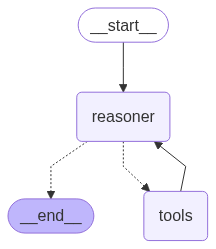

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]

In [ ]:
for m in messages['messages']:
    m.pretty_print()